In [1]:
from __future__ import print_function
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from IPython.display import clear_output

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from torch.nn import init
import torchvision.transforms as transforms
from  torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler


from sklearn.metrics import confusion_matrix
from skimage import io, transform

import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import csv
import os
import math
import random
import cv2

In [2]:
is_notebook = True

In [14]:
if is_notebook:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm


### Utils

In [137]:
"""This module contains simple helper functions """
import torch
import numpy as np
from PIL import Image
import os


def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)


def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)

    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)


def save_image(image_numpy, image_path, aspect_ratio=1.0):
    """Save a numpy image to the disk

    Parameters:
        image_numpy (numpy array) -- input numpy array
        image_path (str)          -- the path of the image
    """

    image_pil = Image.fromarray(image_numpy)
    h, w, _ = image_numpy.shape

    if aspect_ratio > 1.0:
        image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
    if aspect_ratio < 1.0:
        image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
    image_pil.save(image_path)


def print_numpy(x, val=True, shp=False):
    """Print the mean, min, max, median, std, and size of a numpy array

    Parameters:
        val (bool) -- if print the values of the numpy array
        shp (bool) -- if print the shape of the numpy array
    """
    x = x.astype(np.float64)
    if shp:
        print('shape,', x.shape)
    if val:
        x = x.flatten()
        print('mean = %3.3f, min = %3.3f, max = %3.3f, median = %3.3f, std=%3.3f' % (
            np.mean(x), np.min(x), np.max(x), np.median(x), np.std(x)))


def mkdirs(paths):
    """create empty directories if they don't exist

    Parameters:
        paths (str list) -- a list of directory paths
    """
    if isinstance(paths, list) and not isinstance(paths, str):
        for path in paths:
            mkdir(path)
    else:
        mkdir(paths)


def mkdir(path):
    """create a single empty directory if it didn't exist

    Parameters:
        path (str) -- a single directory path
    """
    if not os.path.exists(path):
        os.makedirs(path)


### Networks

In [144]:
import functools

class Identity(nn.Module):
    def forward(self, x):
        return x


def get_norm_layer(norm_type='instance'):
    """Return a normalization layer

    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none

    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def get_scheduler(optimizer, opt):
    """Return a learning rate scheduler

    Parameters:
        optimizer          -- the optimizer of the network
        opt (option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions．　
                              opt.lr_policy is the name of learning rate policy: linear | step | plateau | cosine

    For 'linear', we keep the same learning rate for the first <opt.n_epochs> epochs
    and linearly decay the rate to zero over the next <opt.n_epochs_decay> epochs.
    For other schedulers (step, plateau, and cosine), we use the default PyTorch schedulers.
    See https://pytorch.org/docs/stable/optim.html for more details.
    """
    if opt.lr_policy == 'linear':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.n_epochs) / float(opt.n_epochs_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.n_epochs, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>


def init_net(net, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Initialize a network: 1. register CPU/GPU device (with multi-GPU support); 2. initialize the network weights
    Parameters:
        net (network)      -- the network to be initialized
        init_type (str)    -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        gain (float)       -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Return an initialized network.
    """
    if len(gpu_ids) > 0:
        assert(torch.cuda.is_available())
        net.to(gpu_ids[0])
        net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs
    init_weights(net, init_type, init_gain=init_gain)
    return net


def define_G(input_nc, output_nc, ngf, netG, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a generator

    Parameters:
        input_nc (int) -- the number of channels in input images
        output_nc (int) -- the number of channels in output images
        ngf (int) -- the number of filters in the last conv layer
        netG (str) -- the architecture's name: resnet_9blocks | resnet_6blocks | unet_256 | unet_128
        norm (str) -- the name of normalization layers used in the network: batch | instance | none
        use_dropout (bool) -- if use dropout layers.
        init_type (str)    -- the name of our initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a generator

    Our current implementation provides two types of generators:
        U-Net: [unet_128] (for 128x128 input images) and [unet_256] (for 256x256 input images)
        The original U-Net paper: https://arxiv.org/abs/1505.04597

        Resnet-based generator: [resnet_6blocks] (with 6 Resnet blocks) and [resnet_9blocks] (with 9 Resnet blocks)
        Resnet-based generator consists of several Resnet blocks between a few downsampling/upsampling operations.
        We adapt Torch code from Justin Johnson's neural style transfer project (https://github.com/jcjohnson/fast-neural-style).


    The generator has been initialized by <init_net>. It uses RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netG == 'resnet_9blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
    elif netG == 'resnet_6blocks':
        net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6)
    elif netG == 'unet_128':
        net = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    elif netG == 'unet_256':
        net = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % netG)
    return init_net(net, init_type, init_gain, gpu_ids)


def define_D(input_nc, ndf, netD, n_layers_D=3, norm='batch', init_type='normal', init_gain=0.02, gpu_ids=[]):
    """Create a discriminator

    Parameters:
        input_nc (int)     -- the number of channels in input images
        ndf (int)          -- the number of filters in the first conv layer
        netD (str)         -- the architecture's name: basic | n_layers | pixel
        n_layers_D (int)   -- the number of conv layers in the discriminator; effective when netD=='n_layers'
        norm (str)         -- the type of normalization layers used in the network.
        init_type (str)    -- the name of the initialization method.
        init_gain (float)  -- scaling factor for normal, xavier and orthogonal.
        gpu_ids (int list) -- which GPUs the network runs on: e.g., 0,1,2

    Returns a discriminator

    Our current implementation provides three types of discriminators:
        [basic]: 'PatchGAN' classifier described in the original pix2pix paper.
        It can classify whether 70×70 overlapping patches are real or fake.
        Such a patch-level discriminator architecture has fewer parameters
        than a full-image discriminator and can work on arbitrarily-sized images
        in a fully convolutional fashion.

        [n_layers]: With this mode, you can specify the number of conv layers in the discriminator
        with the parameter <n_layers_D> (default=3 as used in [basic] (PatchGAN).)

        [pixel]: 1x1 PixelGAN discriminator can classify whether a pixel is real or not.
        It encourages greater color diversity but has no effect on spatial statistics.

    The discriminator has been initialized by <init_net>. It uses Leakly RELU for non-linearity.
    """
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':  # default PatchGAN classifier
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer)
    elif netD == 'n_layers':  # more options
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer)
    elif netD == 'pixel':     # classify if each pixel is real or fake
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % netD)
    return init_net(net, init_type, init_gain, gpu_ids)


##############################################################################
# Classes
##############################################################################
class GANLoss(nn.Module):
    """Define different GAN objectives.

    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.

        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image

        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


def cal_gradient_penalty(netD, real_data, fake_data, device, type='mixed', constant=1.0, lambda_gp=10.0):
    """Calculate the gradient penalty loss, used in WGAN-GP paper https://arxiv.org/abs/1704.00028

    Arguments:
        netD (network)              -- discriminator network
        real_data (tensor array)    -- real images
        fake_data (tensor array)    -- generated images from the generator
        device (str)                -- GPU / CPU: from torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')
        type (str)                  -- if we mix real and fake data or not [real | fake | mixed].
        constant (float)            -- the constant used in formula ( | |gradient||_2 - constant)^2
        lambda_gp (float)           -- weight for this loss

    Returns the gradient penalty loss
    """
    if lambda_gp > 0.0:
        if type == 'real':   # either use real images, fake images, or a linear interpolation of two.
            interpolatesv = real_data
        elif type == 'fake':
            interpolatesv = fake_data
        elif type == 'mixed':
            alpha = torch.rand(real_data.shape[0], 1, device=device)
            alpha = alpha.expand(real_data.shape[0], real_data.nelement() // real_data.shape[0]).contiguous().view(*real_data.shape)
            interpolatesv = alpha * real_data + ((1 - alpha) * fake_data)
        else:
            raise NotImplementedError('{} not implemented'.format(type))
        interpolatesv.requires_grad_(True)
        disc_interpolates = netD(interpolatesv)
        gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolatesv,
                                        grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                        create_graph=True, retain_graph=True, only_inputs=True)
        gradients = gradients[0].view(real_data.size(0), -1)  # flat the data
        gradient_penalty = (((gradients + 1e-16).norm(2, dim=1) - constant) ** 2).mean() * lambda_gp        # added eps
        return gradient_penalty, gradients
    else:
        return 0.0, None


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out


class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)


class PixelDiscriminator(nn.Module):
    """Defines a 1x1 PatchGAN discriminator (pixelGAN)"""

    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d):
        """Construct a 1x1 PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        """
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        """Standard forward."""
        return self.net(input)


### Models

In [216]:
def find_model_using_name(model_name):
    """Import the module "models/[model_name]_model.py".

    In the file, the class called DatasetNameModel() will
    be instantiated. It has to be a subclass of BaseModel,
    and it is case-insensitive.
    """
    model = Pix2PixModel
    return model


def get_option_setter(model_name):
    """Return the static method <modify_commandline_options> of the model class."""
    model_class = find_model_using_name(model_name)
    return model_class.modify_commandline_options


def create_model(opt):
    """Create a model given the option.

    This function warps the class CustomDatasetDataLoader.
    This is the main interface between this package and 'train.py'/'test.py'

    Example:
        >>> from models import create_model
        >>> model = create_model(opt)
    """
    model = find_model_using_name(opt.model)
    instance = model(opt)
    print("model [%s] was created" % type(instance).__name__)
    return instance



import os
import torch
from collections import OrderedDict
from abc import ABC, abstractmethod


class BaseModel(ABC):
    """This class is an abstract base class (ABC) for models.
    To create a subclass, you need to implement the following five functions:
        -- <__init__>:                      initialize the class; first call BaseModel.__init__(self, opt).
        -- <set_input>:                     unpack data from dataset and apply preprocessing.
        -- <forward>:                       produce intermediate results.
        -- <optimize_parameters>:           calculate losses, gradients, and update network weights.
        -- <modify_commandline_options>:    (optionally) add model-specific options and set default options.
    """

    def __init__(self, opt):
        """Initialize the BaseModel class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions

        When creating your custom class, you need to implement your own initialization.
        In this function, you should first call <BaseModel.__init__(self, opt)>
        Then, you need to define four lists:
            -- self.loss_names (str list):          specify the training losses that you want to plot and save.
            -- self.model_names (str list):         define networks used in our training.
            -- self.visual_names (str list):        specify the images that you want to display and save.
            -- self.optimizers (optimizer list):    define and initialize optimizers. You can define one optimizer for each network. If two networks are updated at the same time, you can use itertools.chain to group them. See cycle_gan_model.py for an example.
        """
        self.opt = opt
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu')  # get device name: CPU or GPU
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        if opt.preprocess != 'scale_width':  # with [scale_width], input images might have different sizes, which hurts the performance of cudnn.benchmark.
            torch.backends.cudnn.benchmark = True
        self.loss_names = []
        self.model_names = []
        self.visual_names = []
        self.optimizers = []
        self.image_paths = []
        self.metric = 0  # used for learning rate policy 'plateau'

    @staticmethod
    def modify_commandline_options(parser, is_train):
        """Add new model-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.
        """
        return parser

    @abstractmethod
    def set_input(self, inputs, targets):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): includes the data itself and its metadata information.
        """
        pass

    @abstractmethod
    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        pass

    @abstractmethod
    def optimize_parameters(self):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        pass

    def setup(self, opt):
        """Load and print networks; create schedulers

        Parameters:
            opt (Option class) -- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        if self.isTrain:
            self.schedulers = [get_scheduler(optimizer, opt) for optimizer in self.optimizers]
        if not self.isTrain or opt.continue_train:
            load_suffix = 'iter_%d' % opt.load_iter if opt.load_iter > 0 else opt.epoch
            self.load_networks(load_suffix)
        self.print_networks(opt.verbose)

    def eval(self):
        """Make models eval mode during test time"""
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                net.eval()

    def test(self):
        """Forward function used in test time.

        This function wraps <forward> function in no_grad() so we don't save intermediate steps for backprop
        It also calls <compute_visuals> to produce additional visualization results
        """
        with torch.no_grad():
            self.forward()
            self.compute_visuals()

    def compute_visuals(self):
        """Calculate additional output images for visdom and HTML visualization"""
        pass

    def get_image_paths(self):
        """ Return image paths that are used to load current data"""
        return self.image_paths

    def update_learning_rate(self):
        """Update learning rates for all the networks; called at the end of every epoch"""
        for scheduler in self.schedulers:
            if self.opt.lr_policy == 'plateau':
                scheduler.step(self.metric)
            else:
                scheduler.step()

        lr = self.optimizers[0].param_groups[0]['lr']
        print('learning rate = %.7f' % lr)

    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret

    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret

    def save_networks(self, epoch):
        """Save all the networks to the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.module.cpu().state_dict(), save_path)
                    net.cuda(self.gpu_ids[0])
                else:
                    torch.save(net.cpu().state_dict(), save_path)

    def __patch_instance_norm_state_dict(self, state_dict, module, keys, i=0):
        """Fix InstanceNorm checkpoints incompatibility (prior to 0.4)"""
        key = keys[i]
        if i + 1 == len(keys):  # at the end, pointing to a parameter/buffer
            if module.__class__.__name__.startswith('InstanceNorm') and \
                    (key == 'running_mean' or key == 'running_var'):
                if getattr(module, key) is None:
                    state_dict.pop('.'.join(keys))
            if module.__class__.__name__.startswith('InstanceNorm') and \
               (key == 'num_batches_tracked'):
                state_dict.pop('.'.join(keys))
        else:
            self.__patch_instance_norm_state_dict(state_dict, getattr(module, key), keys, i + 1)

    def load_networks(self, epoch):
        """Load all the networks from the disk.

        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)

    def print_networks(self, verbose):
        """Print the total number of parameters in the network and (if verbose) network architecture

        Parameters:
            verbose (bool) -- if verbose: print the network architecture
        """
        print('---------- Networks initialized -------------')
        for name in self.model_names:
            if isinstance(name, str):
                net = getattr(self, 'net' + name)
                num_params = 0
                for param in net.parameters():
                    num_params += param.numel()
                if verbose:
                    print(net)
                print('[Network %s] Total number of parameters : %.3f M' % (name, num_params / 1e6))
        print('-----------------------------------------------')

    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad


In [217]:

class Pix2PixModel(BaseModel):
    """ This class implements the pix2pix model, for learning a mapping from input images to output images given paired data.

    The model training requires '--dataset_mode aligned' dataset.
    By default, it uses a '--netG unet256' U-Net generator,
    a '--netD basic' discriminator (PatchGAN),
    and a '--gan_mode' vanilla GAN loss (the cross-entropy objective used in the orignal GAN paper).

    pix2pix paper: https://arxiv.org/pdf/1611.07004.pdf
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options.

        Parameters:
            parser          -- original option parser
            is_train (bool) -- whether training phase or test phase. You can use this flag to add training-specific or test-specific options.

        Returns:
            the modified parser.

        For pix2pix, we do not use image buffer
        The training objective is: GAN Loss + lambda_L1 * ||G(A)-B||_1
        By default, we use vanilla GAN loss, UNet with batchnorm, and aligned datasets.
        """
        # changing the default values to match the pix2pix paper (https://phillipi.github.io/pix2pix/)
        parser.set_defaults(norm='batch', netG='unet_256', dataset_mode='aligned')
        if is_train:
            parser.set_defaults(pool_size=0, gan_mode='vanilla')
            parser.add_argument('--lambda_L1', type=float, default=100.0, help='weight for L1 loss')

        return parser

    def __init__(self, opt):
        """Initialize the pix2pix class.

        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseModel.__init__(self, opt)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['G_GAN', 'G_L1', 'D_real', 'D_fake']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        self.visual_names = ['real_A', 'fake_B', 'real_B']
        # specify the models you want to save to the disk. The training/test scripts will call <BaseModel.save_networks> and <BaseModel.load_networks>
        if self.isTrain:
            self.model_names = ['G', 'D']
        else:  # during test time, only load G
            self.model_names = ['G']
        # define networks (both generator and discriminator)
        self.netG = define_G(opt.input_nc, opt.output_nc, opt.ngf, opt.netG, opt.norm,
                                      not opt.no_dropout, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:  # define a discriminator; conditional GANs need to take both input and output images; Therefore, #channels for D is input_nc + output_nc
            self.netD = define_D(opt.input_nc + opt.output_nc, opt.ndf, opt.netD,
                                          opt.n_layers_D, opt.norm, opt.init_type, opt.init_gain, self.gpu_ids)

        if self.isTrain:
            # define loss functions
            self.criterionGAN = GANLoss(opt.gan_mode).to(self.device)
            self.criterionL1 = torch.nn.L1Loss()
            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
            self.optimizers.append(self.optimizer_G)
            self.optimizers.append(self.optimizer_D)

    def set_input(self, inputs, targets):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.

        Parameters:
            input (dict): include the data itself and its metadata information.

        The option 'direction' can be used to swap images in domain A and domain B.
        """
        self.real_A = inputs.to(self.device)
        self.real_B = targets.to(self.device)

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.fake_B = self.netG(self.real_A)  # G(A)


    def backward_D(self):
        """Calculate GAN loss for the discriminator"""
        # Fake; stop backprop to the generator by detaching fake_B
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)  # we use conditional GANs; we need to feed both input and output to the discriminator

        pred_fake = self.netD(fake_AB.detach())

        self.loss_D_fake = self.criterionGAN(pred_fake, False)
        # Real
        real_AB = torch.cat((self.real_A, self.real_B), 1)
        pred_real = self.netD(real_AB)
        self.loss_D_real = self.criterionGAN(pred_real, True)
        # combine loss and calculate gradients
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        """Calculate GAN and L1 loss for the generator"""
        # First, G(A) should fake the discriminator
        fake_AB = torch.cat((self.real_A, self.fake_B), 1)

        pred_fake = self.netD(fake_AB)
        self.loss_G_GAN = self.criterionGAN(pred_fake, True)
        # Second, G(A) = B
        self.loss_G_L1 = self.criterionL1(self.fake_B, self.real_B) * self.opt.lambda_L1
        # combine loss and calculate gradients
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize_parameters(self):
        self.forward()                   # compute fake images: G(A)
        # update D
        self.set_requires_grad(self.netD, True)  # enable backprop for D
        self.optimizer_D.zero_grad()     # set D's gradients to zero
        self.backward_D()                # calculate gradients for D
        self.optimizer_D.step()          # update D's weights
        # update G
        self.set_requires_grad(self.netD, False)  # D requires no gradients when optimizing G
        self.optimizer_G.zero_grad()        # set G's gradients to zero
        self.backward_G()                   # calculate graidents for G
        self.optimizer_G.step()             # udpate G's weights


### Options

In [218]:
import argparse
import os

class BaseOptions():
    """This class defines options used during both training and test time.

    It also implements several helper functions such as parsing, printing, and saving the options.
    It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
    """

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):
        """Define the common options that are used in both training and test."""
        # basic parameters
        #parser.add_argument('--dataroot', required=True, help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
        parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        self.initialized = True
        return parser

    def gather_options(self):
        """Initialize our parser with basic options(only once).
        Add additional model-specific and dataset-specific options.
        These options are defined in the <modify_commandline_options> function
        in model and dataset classes.
        """
        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args()

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args()  # parse again with new defaults

        # modify dataset-related parser options
        #dataset_name = opt.dataset_mode
        #dataset_option_setter = data.get_option_setter(dataset_name)
        #parser = dataset_option_setter(parser, self.isTrain)

        # save and return the parser
        self.parser = parser
        opt, _ = parser.parse_known_args()
        return opt

    def print_options(self, opt):
        """Print and save options

        It will print both current options and default values(if different).
        It will save options into a text file / [checkpoints_dir] / opt.txt
        """
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

        # save to the disk
#         expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
#         #mkdirs(expr_dir)
#         file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
#         with open(file_name, 'wt') as opt_file:
#             opt_file.write(message)
#             opt_file.write('\n')

    def parse(self):

        """Parse our options, create checkpoints directory suffix, and set up gpu device."""
        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])
        self.opt = opt
        return self.opt


In [219]:
class TrainOptions(BaseOptions):
    """This class includes training options.

    It also includes shared options defined in BaseOptions.
    """

    def initialize(self, parser):
        parser = BaseOptions.initialize(self, parser)
        # visdom and HTML visualization parameters
        parser.add_argument('--display_freq', type=int, default=400, help='frequency of showing training results on screen')
        parser.add_argument('--display_ncols', type=int, default=4, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
        parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
        parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
        parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
        parser.add_argument('--display_port', type=int, default=8097, help='visdom port of the web display')
        parser.add_argument('--update_html_freq', type=int, default=1000, help='frequency of saving training results to html')
        parser.add_argument('--print_freq', type=int, default=100, help='frequency of showing training results on console')
        parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')
        # network saving and loading parameters
        parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
        parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
        parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
        parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
        parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
        parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
        # training parameters
        parser.add_argument('--n_epochs', type=int, default=100, help='number of epochs with the initial learning rate')
        parser.add_argument('--n_epochs_decay', type=int, default=100, help='number of epochs to linearly decay learning rate to zero')
        parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
        parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam')
        parser.add_argument('--gan_mode', type=str, default='lsgan', help='the type of GAN objective. [vanilla| lsgan | wgangp]. vanilla GAN loss is the cross-entropy objective used in the original GAN paper.')
        parser.add_argument('--pool_size', type=int, default=50, help='the size of image buffer that stores previously generated images')
        parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
        parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')

        self.isTrain = True
        return parser


In [220]:
import os
def get_meta(root_dir):
    """ Fetches the meta data for all the images and assigns labels.
    """
    paths = []
    
    for entry in os.scandir(root_dir):
        if (entry.is_file()):
            paths.append(entry.path)
    return paths

In [221]:
if is_notebook:
    root_dir_A = "./data/trainA/"
    root_dir_B = "./data/trainB/"
else:
    root_dir_A = "/nobackup/sc19adpm/DeepStreetsData/trainA/"
    root_dir_B = "/nobackup/sc19adpm/DeepStreetsData/trainB/"

paths_A = get_meta(root_dir_A)[:100]
paths_B = get_meta(root_dir_B)[:100]

data = {
    'A': paths_A,
    'B': paths_B
}
data_df = pd.DataFrame(data, columns=['A', 'B'])
data_df = data_df.sample(frac=1).reset_index(drop=True)

In [222]:
data_df.head()

,A,B
0,./data/trainA/se3035_22.jpg,./data/trainB/se3035_22.jpg
1,./data/trainA/se3135_116.jpg,./data/trainB/se3135_116.jpg
2,./data/trainA/se2838_40.jpg,./data/trainB/se2838_40.jpg
3,./data/trainA/se2536_69.jpg,./data/trainB/se2536_69.jpg
4,./data/trainA/se2837_10.jpg,./data/trainB/se2837_10.jpg


In [223]:
def compute_img_mean_std(image_paths):
    """
        Author: @xinruizhuang. Computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 256, 256
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means, stdevs

In [224]:
#norm_mean_A, norm_std_A = compute_img_mean_std(paths_A)

In [225]:
#norm_mean_B, norm_std_B = compute_img_mean_std(paths_B)

In [226]:
from PIL import Image
import cv2
from torch.utils.data import Dataset

class Streets(Dataset):
    def __init__(self, df, transform_A, transform_B):
        self.df = df
        self.transform_A = transform_A
        self.transform_B = transform_B
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        x = Image.open(open(self.df['A'][index], 'rb')) 
        y = Image.open(open(self.df['B'][index], 'rb')) 
        
        x = self.transform_A(x)
        y = self.transform_B(y)
        return x, y 
        

In [227]:
def __crop(img, pos, size):
    ow, oh = img.size
    x1, y1 = pos
    tw = th = size
    if (ow > tw or oh > th):
        return img.crop((x1, y1, x1 + tw, y1 + th))
    return img

def __flip(img, flip):
    if flip:
        return img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

In [228]:
w = 256
h = 256
new_h = h
new_w = w
new_h = 256
new_w = 256

x = random.randint(0, np.maximum(0, new_w - 256))
y = random.randint(0, np.maximum(0, new_h - 256))

flip = random.random() > 0.5


data_transform_A = transforms.Compose([
        transforms.Resize((256,256), Image.BICUBIC),
        transforms.Lambda(lambda img: __crop(img, (x, y), 256)),
        transforms.Lambda(lambda img: __flip(img, flip)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Should we use a transform for B too? (Yes, they do)
data_transform_B = transforms.Compose([
        transforms.Resize((256,256), Image.BICUBIC),
        transforms.Lambda(lambda img: __crop(img, (x, y), 256)),
        transforms.Lambda(lambda img: __flip(img, flip)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [229]:
train_split = 1 # Defines the ratio of train/valid/test data.
valid_split = 0

train_size = int(len(data_df)*train_split)
valid_size = int(len(data_df)*valid_split)

ins_dataset_train = Streets(
    df=data_df[:train_size],
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_valid = Streets(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

ins_dataset_test = Streets(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    transform_A=data_transform_A,
    transform_B=data_transform_B
)

In [230]:
batch_size = 1
train_loader = DataLoader(dataset=ins_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=ins_dataset_test, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(dataset=ins_dataset_valid, batch_size=batch_size, shuffle=False)

In [231]:
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)

In [232]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
opt = TrainOptions().parse()   # get training options

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
             dataset_mode: aligned                       
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: van

In [233]:
model = Pix2PixModel(opt)
model.setup(opt)

initialize network with normal
initialize network with normal
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.414 M
[Network D] Total number of parameters : 2.769 M
-----------------------------------------------


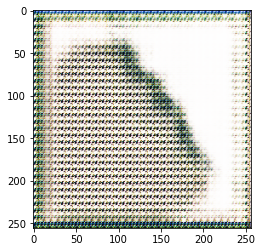

Epoch [219/1000], Step [1/100]



KeyboardInterrupt: 

In [234]:
# Train the model
train_loss_list = []
train_acc_list = []

num_epochs = 1000
for epoch in range(num_epochs):
    loss_D_list = []
    loss_G_list = []
    acc_list = []
    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        
        model.set_input(inputs, targets)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights
        model.forward()

        
        
        if (is_notebook) and (i % 100 == 0):
            clear_output(wait=True)
            plt.figure(0) # Here's the part I need
            img = tensor2im(model.fake_B)
            plt.imshow(img)
            plt.show()
            print('Epoch [{}/{}], Step [{}/{}]'
                  .format(epoch + 1, num_epochs, i+1, len(train_loader)))
        
        # Track the accuracy
    model.update_learning_rate()    
    print('Epoch [{}/{}]'
              .format(epoch + 1, num_epochs))
    if (not is_notebook) and (epoch % 5 == 0):
        idx = random.randint(0, len(paths_A) - 1)
        img_A = Image.open(paths_A[idx])
        img = data_transform_A(img_A)
        img = torch.from_numpy(np.expand_dims(img, axis=0))
        img = img.to(model.device)
        out = model.netG(img)
        img_B_fake = tensor2im(out)
        img_B_real = Image.open(paths_B[idx])
        img = np.concatenate((img_A, img_B_fake, img_B_real), axis=1) 
        plt.imshow(img)
        plt.show()
        plt.imsave('results/{}.jpg'.format(epoch), img)